In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flikart-grid/home_sdf_marketing_sample_for_flipkart_com-ecommerce__20191101_20191130__15k_data.csv
/kaggle/input/flikart-grid/flipkart_com-ecommerce_sample.json
/kaggle/input/flikart-grid/clean_sdf_2400.csv


In [2]:
!pip install -r /kaggle/working/requirements.txt -q 

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/kaggle/working/requirements.txt'


In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm 
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch 
import torchvision 
import os
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import textwrap


In [5]:
class Config:
    def __init__(self , csv_path , image_dir , device, saved_csv_path):
        self.csv_path = csv_path 
        self.image_dir = image_dir 
        self.device = device 
        self.saved_csv_path = saved_csv_path
config = Config(csv_path = "/kaggle/input/flikart-grid/home_sdf_marketing_sample_for_flipkart_com-ecommerce__20191101_20191130__15k_data.csv",
               image_dir = "/kaggle/working/SDF-Images" , 
                device = "cuda" if torch.cuda.is_available() else "cpu",
                saved_csv_path = "/kaggle/working/data_images01.csv"
               )

## EDA and Data Wrangling 

In [10]:
data = pd.read_csv(config.csv_path ,  on_bad_lines="skip")
data.sample(10)

Uniq Id           Crawl Timestamp  \
2433   06ba6ff8993542cdc48f6aa9994243e7  2019-11-05 00:26:49 0000   
4875   3b6f2fe309c0386aab7160b064e9de42  2019-11-26 00:26:44 0000   
1782   f8a9c543a11856401f3eca42057a012d  2019-11-16 00:26:58 0000   
10191  606de5034f6333a7a917ece1b07b45a1  2019-11-21 00:25:13 0000   
338    42edff96de6820c46e7d949703ca2028  2019-11-28 00:29:19 0000   
9597   316023b371cfb4311517898ee4a65ccd  2019-11-03 00:34:00 0000   
13146  d796264bbb87215316a13caca5741a35  2019-11-16 00:37:39 0000   
10772  0b243b6a3dd59550e203696f42bb3781  2019-11-23 02:52:05 0000   
6847   e0d9cadf0444d9d8469426c62e3769ea  2019-11-13 00:24:24 0000   
14906  19200ac78f72b85b1d9610c2cdf02a39  2019-11-21 00:40:13 0000   

                  Bb Category  \
2433         Masalas & Spices   
4875       Ketchups & Spreads   
1782                   Juices   
10191   Sugar, Jaggery & Salt   
338         Soaps & Body Wash   
9597            Ready To Cook   
13146   Baby Bath & Skin Care   
10772           Dals & Pulses   
6847   Chips,Namkeen & Snacks   
14906  Floor & Other Cleaners   

                                           Product Title  \
2433                      Keya Italian Seasoning  (35 g)   
4875             Fun Foods Sandwich Spread Eggless 300 g   
1782                Paper Boat Juice- Mixed Fruit  (1 L)   
10191                  Akar Crystal Iodized Salt  (1 kg)   
338    Godrej No.1 Rosewater & Almond Soap  (Buy 3 Ge...   
9597                         Gits Rose Falooda Mix 200 g   
13146             Himalaya Gentle Baby Shampoo  (200 ml)   
10772                  Organic Tattva Mix Beans  (500 g)   
6847                          Haldiram's Mathri  (200 g)   
14906               Cif Floor Cleaner Wild Orchid  (1 L)   

                                     Product Description           Brand  \
2433                                                 NaN            Keya   
4875                                                 NaN       Fun Foods   
1782                                                 NaN      Paper Boat   
10191                                                NaN            Akar   
338                                                  NaN     Godrej No.1   
9597                                                 NaN            Gits   
13146  While caring for newborns, it is highly import...        Himalaya   
10772                                                NaN  Organic Tattva   
6847                                                 NaN      Haldiram's   
14906  Experience the beauty of Cif Wild Orchid Floor...             Cif   

      Quantity Or Pack Size  Mrp Price     Site Name  \
2433                   35 g   99    93  flipkart_com   
4875                  300 g   79    75  flipkart_com   
1782          1 L Tetrapack  110    99  flipkart_com   
10191                  1 kg   19    15  flipkart_com   
338                 3x100 g   68    68  flipkart_com   
9597                  200 g   75    72  flipkart_com   
13146                200 ml  155   131  flipkart_com   
10772                 500 g  120   102  flipkart_com   
6847                  200 g   50    50  flipkart_com   
14906                   1 L  225   168  flipkart_com   

                                                  Offers Combo Offers  \
2433   Bank Offer 5% Unlimited Cashback on Flipkart A...          NaN   
4875   Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
1782   Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
10191  Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
338    Bank Offer 10% Cashback* on HDFC Bank Debit Ca...    100g each   
9597   Bank Offer 5% Unlimited Cashback on Flipkart A...          NaN   
13146  Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
10772  Bank Offer 10% Instant Discount on Federal Ban...          NaN   
6847   Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
14906  Bank Offer 10% Cashback* on HDFC Bank Debit Ca...       

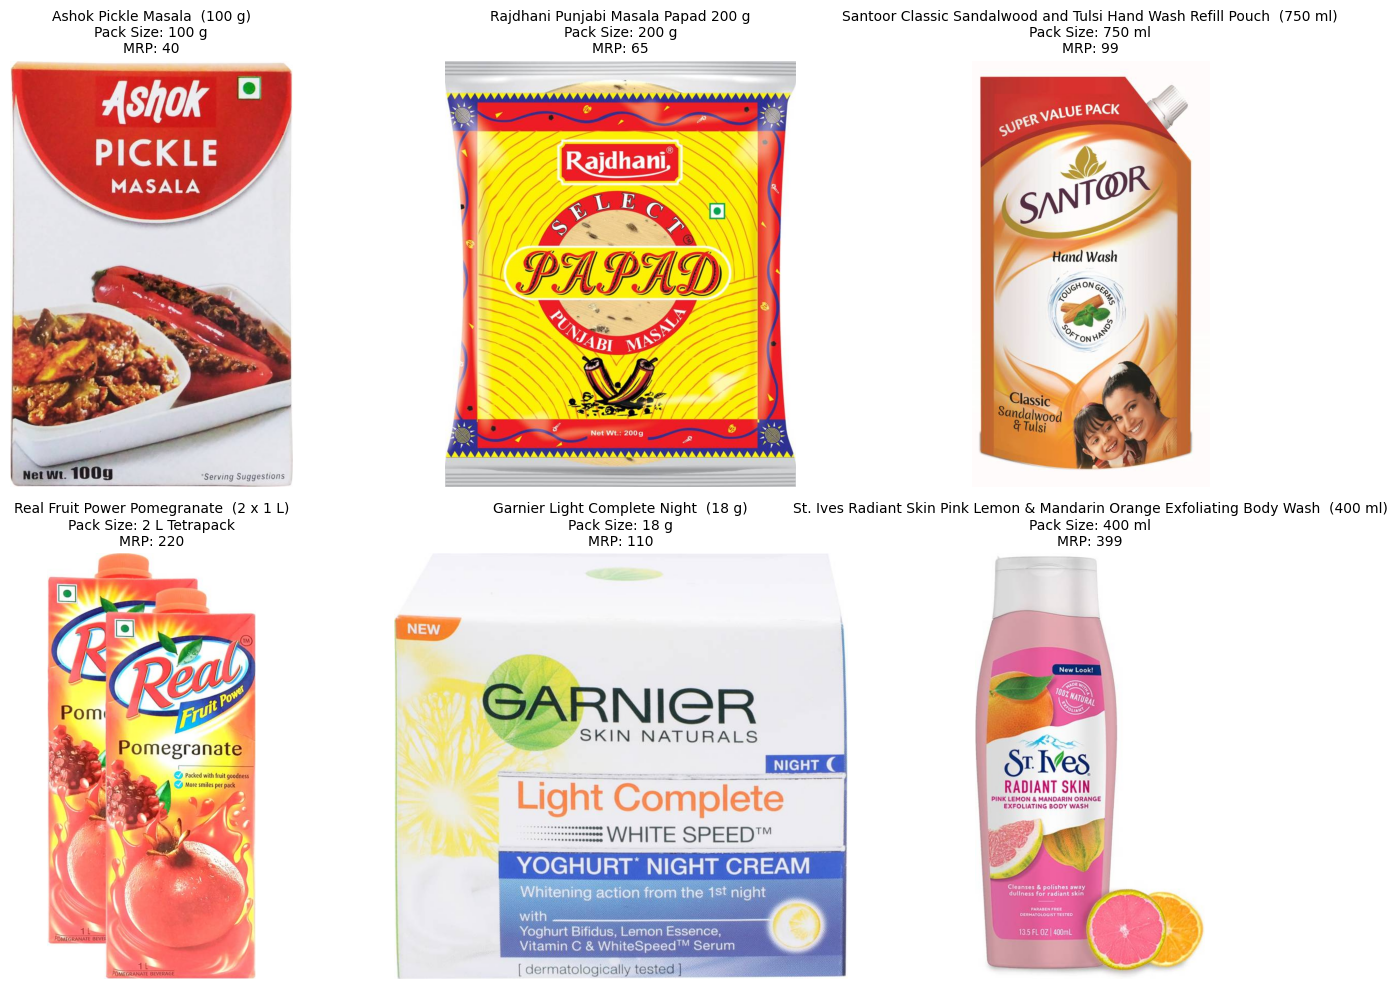

In [12]:
def plot_product_samples(df, sample_size=6):
    # Sample 6 random products from the dataframe
    sample_df = df.sample(sample_size)
    
    # Create a 2x3 plot
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Flatten the axes array for easier iteration
    axs = axs.flatten()
    
    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Get the image from the URL
        try:
            response = requests.get(row['Image Url'].split('|')[0])
            img = Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Error loading image for {row['Product Title']}: {e}")
            img = Image.new('RGB', (200, 200), color='gray')  # Placeholder for missing images

        # Plot the image
        axs[i].imshow(img)
        axs[i].axis('off')

        # Add product information as a title
        axs[i].set_title(f"{row['Product Title']}\n"
                         f"Pack Size: {row['Quantity Or Pack Size']}\n"
                         f"MRP: {row['Mrp']}", fontsize=10)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

plot_product_samples(data)

* Download the data and store them in persistent storage 

In [23]:

# Download the data and store them in persistent storage 
def download_image(row, index, directory):
    """Helper function to download a single image."""
    try:
        image_url = row['Image Url'].split('|')[0]
        response = requests.get(image_url, timeout=10)  # Set timeout for each request
        img = Image.open(BytesIO(response.content))
        
        # Create a filename and save the image
        filename = f"{directory}/image_{index}.jpg"
        img.save(filename)
        return f"image_{index}.jpg"
    except Exception as e:
        # print(f"Error downloading image from {image_url}: {e}")
        return None

def download_images(df, directory='images', max_workers=4):
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    image_filenames = []
    
    # Use ThreadPoolExecutor to parallelize downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for index, row in df.iterrows():
            futures.append(executor.submit(download_image, row, index, directory))

        # Process results as they complete using tqdm for progress tracking
        for future in tqdm(as_completed(futures), total=len(futures)):
            result = future.result()
            if result:
                image_filenames.append(result)

    return image_filenames

# Example usage
image_filenames = download_images(data)


100%|██████████| 14935/14935 [04:19<00:00, 57.50it/s]


rm: cannot remove '/kaggle/working/SDF-Images/': Directory not empty


In [45]:
def download_image(row, index, directory):
    """Helper function to download a single image."""
    try:
        image_url = row['Image Url'].split('|')[0]
        response = requests.get(image_url, timeout=10)  # Set timeout for each request
        img = Image.open(BytesIO(response.content))
        
        # Create a filename and save the image
        filename = f"{directory}/image_{index}.jpg"
        img.save(filename)
        return f"image_{index}.jpg"  # Return the full path of the saved image
    except Exception as e:
        # print(f"Error downloading image from {image_url}: {e}")
        return None

def download_images(df, directory=config.image_dir , max_workers=4):
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    image_filenames = []
    
    # Initialize a new column in DataFrame with None values
    df['Image Filename'] = None

    # Use ThreadPoolExecutor to parallelize downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for index, row in df.iterrows():
            futures.append(executor.submit(download_image, row, index, directory))

        # Process results as they complete using tqdm for progress tracking
        for index, future in enumerate(tqdm(as_completed(futures), total=len(futures))):
            result = future.result()
            if result:
                image_filenames.append(result)
                # Update the DataFrame with the image filename
                df.at[index, 'Image Filename'] = result  # Use .at for setting the value by index

    return df

# Example usage
updated_data = download_images(data)

100%|██████████| 14935/14935 [05:06<00:00, 48.67it/s]


In [46]:
updated_data

Uniq Id           Crawl Timestamp  \
0      0633d9fd9a3271730fae687f105c7a3a  2019-11-12 00:46:19 0000   
1      8687c5317c6629f89fe62e0233563246  2019-11-28 00:31:50 0000   
2      cf7eeba428641c14e43aa18ada1b5491  2019-11-04 00:48:32 0000   
3      9eb4d8359a3cbe7af6c5ac1c3149940e  2019-11-26 00:33:04 0000   
4      b84c9f6fc53da0c6921147063d894703  2019-11-24 00:32:29 0000   
...                                 ...                       ...   
14930  1aafdf2b35d9c5b42bcd50ca95ca07c5  2019-11-13 00:32:53 0000   
14931  41bcf898d3894b9b43cd0d887e227b18  2019-11-05 00:27:54 0000   
14932  c16ecdee65b424a3f66ff04e9d00ba1d  2019-11-21 00:23:53 0000   
14933  3dc4965181d895335c56bb99f55212d2  2019-11-09 00:23:23 0000   
14934  fdadc7850399510b0d81eec6ecd305e6  2019-11-12 01:10:27 0000   

                      Bb Category  \
0                          Juices   
1             Chocolates & Sweets   
2         Household Care|Pet Food   
3      Creams, Lotions, Skin Care   
4                       Hair Care   
...                           ...   
14930                   Oral Care   
14931                      Juices   
14932            Masalas & Spices   
14933      Chips,Namkeen & Snacks   
14934                       Dairy   

                                           Product Title  \
0                 B Natural Dakshin Pink Guava  (750 ml)   
1               Parle Melody Chocolaty Toffee  (195.5 g)   
2         Whiskas Adult (+1 year) Fish 3 kg Dry Cat Food   
3      Enchanteur Romantic Perfumed Body Lotion  (250...   
4            Pantene Hair Fall Control Shampoo  (180 ml)   
...                                                  ...   
14930  Closeup Ever Fresh Toothpaste  (300 g, Pack of 2)   
14931                 Real Activ 100% Apple Juice  (1 L)   
14932                       Satyam Chilly Bedgi  (100 g)   
14933             Haldiram's Classic Nut Cracker  (1 kg)   
14934           Mother Dairy Mango Sweet Lassi  (200 ml)   

                                     Product Description         Brand  \
0                                                    NaN     B Natural   
1                                                    NaN         Parle   
2      These little pockets of fish cat food are goin...       Whiskas   
3                                                    NaN    Enchanteur   
4      If your hair falls frequently and you leave be...       Pantene   
...                                                  ...           ...   
14930                                                NaN       Closeup   
14931                                                NaN          Real   
14932                                                NaN        Satyam   
14933                                                NaN    Haldiram's   
14934                                                NaN  Mother Dairy   

       Quantity Or Pack Size  Mrp Price     Site Name  \
0      750 ml Plastic Bottle   99    95  flipkart_com   
1                    195.5 g   50    50  flipkart_com   
2                       3 kg  800   680  flipkart_com   
3                     250 ml  220   182  flipkart_com   
4                     180 ml  115   112  flipkart_com   
...                      ...  ...   ...           ...   
14930                2x150 g  144   115  flipkart_com   
14931          1 L Tetrapack  130   100  flipkart_com   
14932                  100 g   49    40  flipkart_com   
14933                   1 kg  225   222  flipkart_com   
14934                 200 ml   20    20  flipkart_com   

                                                  Offers Combo Offers  \
0      Bank Offer 5% Unlimited Cashback on Flipkart A...          NaN   
1      Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
2      Bank Offer 5% Unlimited Cashback on Flipkart A...          NaN   
3      Bank Offer 10% Cashback* on HDFC Bank Debit Ca...          NaN   
4      Bank Offer 10% Instant Discount on Federal Ban...          NaN   
...                      

In [57]:
data.info()
data.to_csv(config.saved_csv_path , index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14935 entries, 0 to 14934
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Uniq Id                14935 non-null  object
 1   Crawl Timestamp        14935 non-null  object
 2   Bb Category            14935 non-null  object
 3   Product Title          14935 non-null  object
 4   Product Description    2604 non-null   object
 5   Brand                  14935 non-null  object
 6   Quantity Or Pack Size  14835 non-null  object
 7   Mrp                    14935 non-null  object
 8   Price                  14935 non-null  object
 9   Site Name              14935 non-null  object
 10  Offers                 14782 non-null  object
 11  Combo Offers           652 non-null    object
 12  Stock Availibility     14935 non-null  bool  
 13  Image Url              14934 non-null  object
 14  Url                    14935 non-null  object
 15  Image Filename     

Error loading image from file: image_7858.jpg, [Errno 2] No such file or directory: '/kaggle/working/SDF-Images/image_7858.jpg'
Error loading image from file: image_8434.jpg, [Errno 2] No such file or directory: '/kaggle/working/SDF-Images/image_8434.jpg'


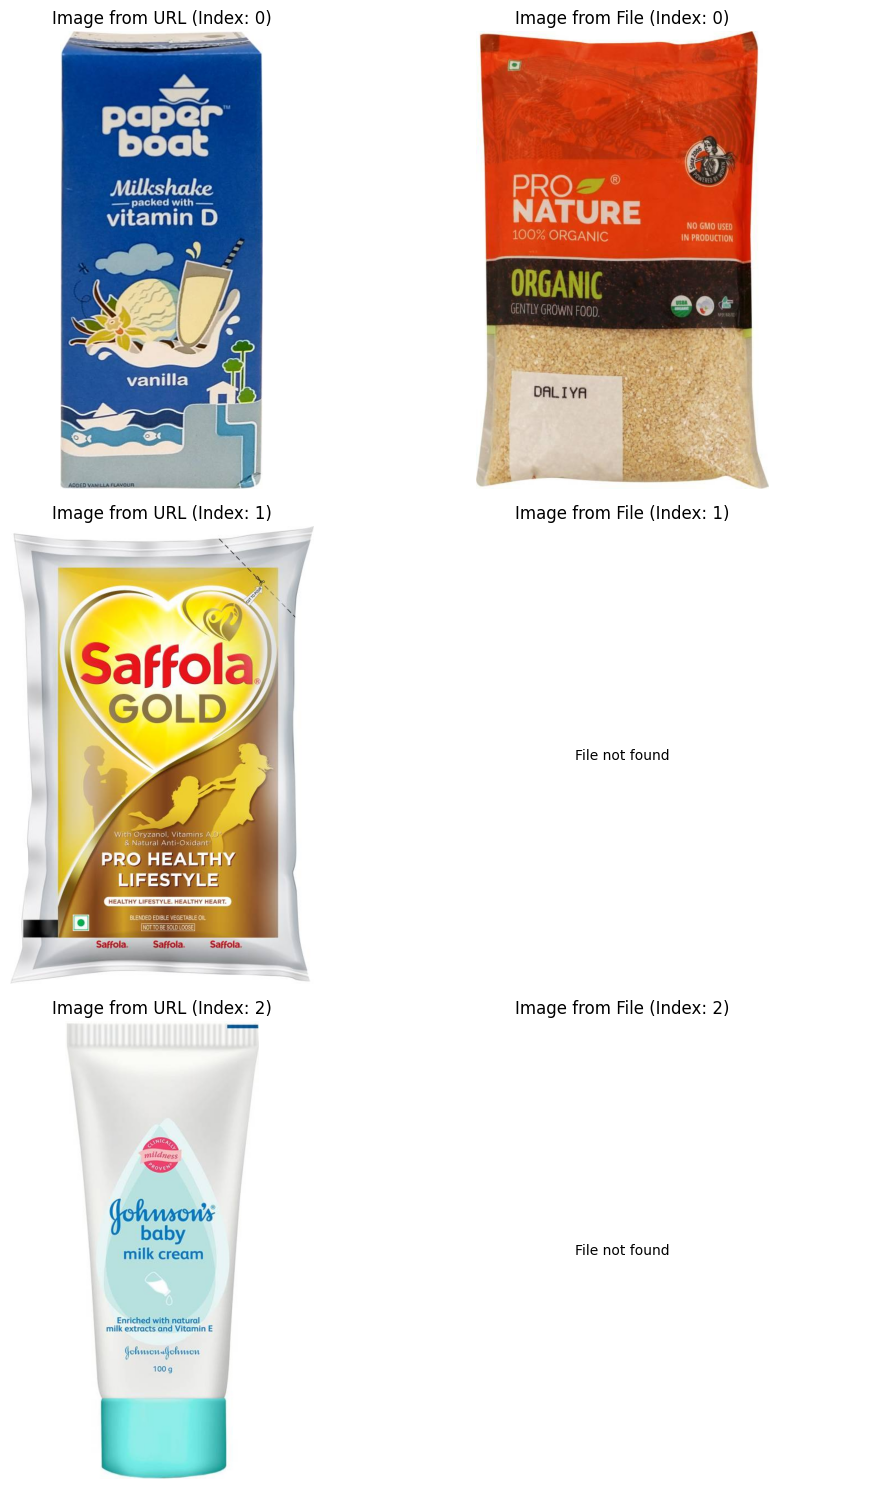

In [10]:
def load_image_from_url(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()  # Raises HTTPError for bad responses
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image from URL: {image_url}, {e}")
        return None

def sanity_check_images(df, n_samples=3):
    # Ensure n_samples does not exceed the number of available samples
    n_samples = min(n_samples, len(df))
    
    # Sample n_samples rows
    sample_df = df.sample(n=n_samples).reset_index(drop=True)

    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 5 * n_samples))
    
    # If n_samples is 1, axes might not be a 2D array
    if n_samples == 1:
        axes = [axes]

    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Load image from URL
        image_url = row.get('Image Url', '').split('|')[0]  # Safely get 'Image Url'
        img_from_url = load_image_from_url(image_url) if image_url else None
        
        # Load image from file
        image_filename = row.get('Image Filename', None)
        img_from_file = None
        if pd.notna(image_filename):
            try:
                img_from_file = Image.open(f"{config.image_dir}/{image_filename}")
            except Exception as e:
                print(f"Error loading image from file: {image_filename}, {e}")
        
        # Display image from URL
        ax_url = axes[i][0] if n_samples > 1 else axes[0]
        if img_from_url:
            ax_url.imshow(img_from_url)
        else:
            ax_url.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
        ax_url.set_title(f'Image from URL (Index: {index})')
        ax_url.axis('off')
    
        # Display image from File
        ax_file = axes[i][1] if n_samples > 1 else axes[1]
        if img_from_file:
            ax_file.imshow(img_from_file)
        else:
            ax_file.text(0.5, 0.5, 'File not found', ha='center', va='center')
        ax_file.set_title(f'Image from File (Index: {index})')
        ax_file.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame and 'config.image_dir' is defined
sanity_check_images(data, n_samples=3)


## GOT OCR2 on extracted Images 

In [19]:
#!pip install tiktoken verovio -q
!pip freeze > /kaggle/working/requirements.txt

In [16]:

tokenizer = AutoTokenizer.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True)
model = AutoModel.from_pretrained('ucaslcl/GOT-OCR2_0', trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True, pad_token_id=tokenizer.eos_token_id)
model = model.eval().cuda()


got_vision_b.py:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- got_vision_b.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


render_tools.py:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- render_tools.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ucaslcl/GOT-OCR2_0:
- got_vision_b.py
- render_tools.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14935 entries, 0 to 14934
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Uniq Id                14935 non-null  object
 1   Crawl Timestamp        14935 non-null  object
 2   Bb Category            14935 non-null  object
 3   Product Title          14935 non-null  object
 4   Product Description    2604 non-null   object
 5   Brand                  14935 non-null  object
 6   Quantity Or Pack Size  14835 non-null  object
 7   Mrp                    14935 non-null  object
 8   Price                  14935 non-null  object
 9   Site Name              14935 non-null  object
 10  Offers                 14782 non-null  object
 11  Combo Offers           652 non-null    object
 12  Stock Availibility     14935 non-null  bool  
 13  Image Url              14934 non-null  object
 14  Url                    14935 non-null  object
 15  Image Filename     

In [30]:
data['Image Url'].iloc[0].split("|")[0]

'https://rukminim1.flixcart.com/image/832/832/jx3kn0w0/drinks-juice/y/h/a/750-dakshin-pink-guava-plastic-bottle-b-natural-original-imafhmmm2yj3nrgw.jpeg?q=70'

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


MELODY PAR LE Melody Chocolat y Melody Rku o


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end gene

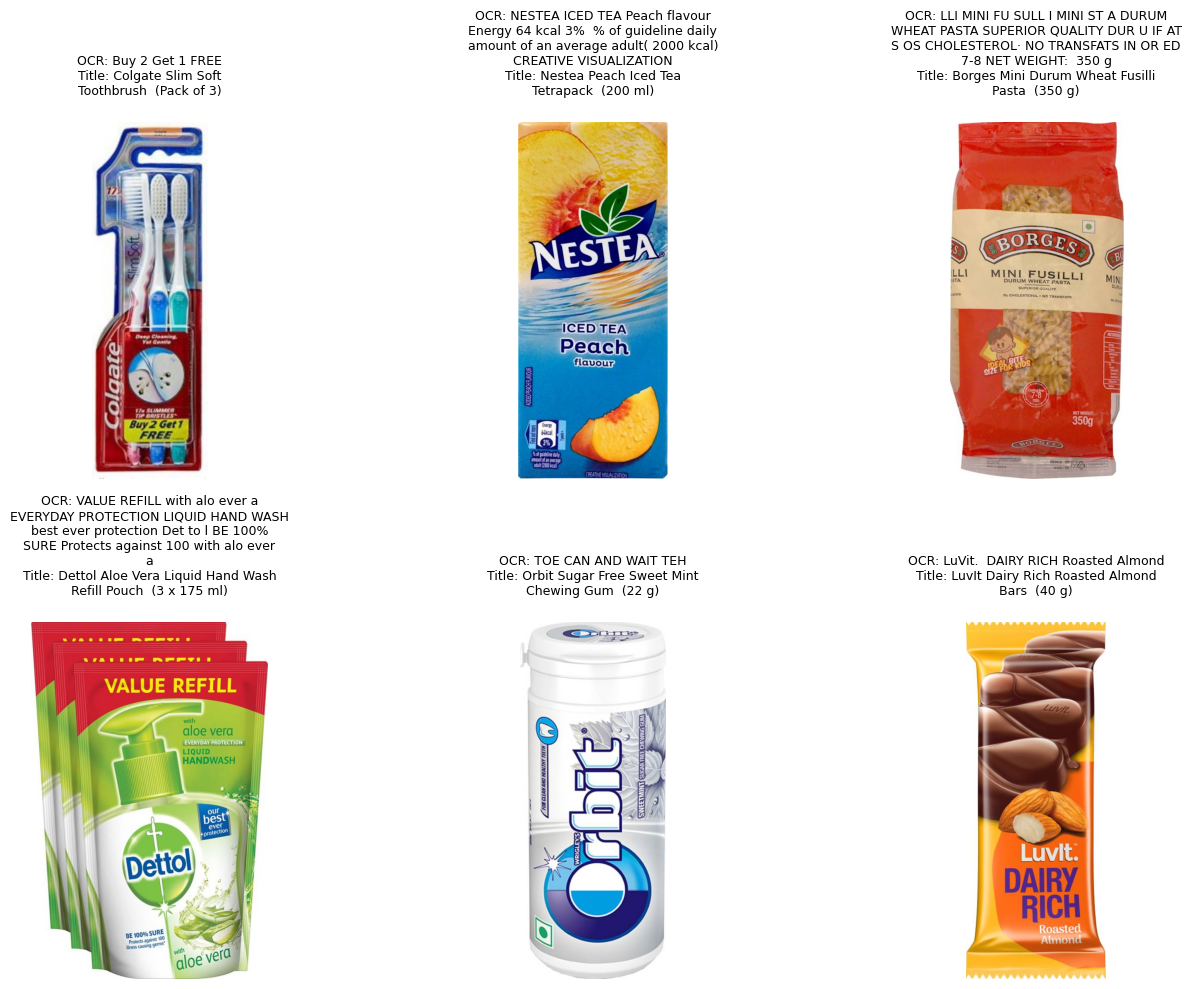

In [43]:
def load_image_from_url(image_url):
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()  # Raises HTTPError for bad responses
        img = Image.open(BytesIO(response.content))
        return img
    except Exception as e:
        print(f"Error loading image from URL: {image_url}, {e}")
        return None

# Function to display random images with OCR results
def display_random_images_with_ocr(df, n_samples=6):
    # Randomly sample 6 rows from the dataset
    sample_df = df.sample(n=n_samples).reset_index(drop=True)

    # Create a 3x2 plot for displaying the images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the axes array for easier indexing

    # Iterate through the sampled DataFrame rows
    for i, row in sample_df.iterrows():
        image_url = row['Image Url'].split("|")[0]  # Get the first image URL if multiple
        product_title = row['Product Title']  # Product title

        # Load and display the image from the URL
        img = load_image_from_url(image_url)
        if img:
            axes[i].imshow(img)
            axes[i].axis('off')  # Remove axis labels

            # Perform OCR and get the result
            ocr_res = model.chat(tokenizer, image_url, ocr_type='ocr')

            # Wrap the OCR result and product title to prevent overlap
            wrapped_ocr = textwrap.fill(f"OCR: {ocr_res}", width=40)
            wrapped_title = textwrap.fill(f"Title: {product_title}", width=40)

            # Set the title with the wrapped OCR result and product title, and adjust padding
            axes[i].set_title(f"{wrapped_ocr}\n{wrapped_title}", fontsize=9, pad=20)
        else:
            axes[i].text(0.5, 0.5, 'Error loading image', ha='center', va='center')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()
display_random_images_with_ocr(data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end gene

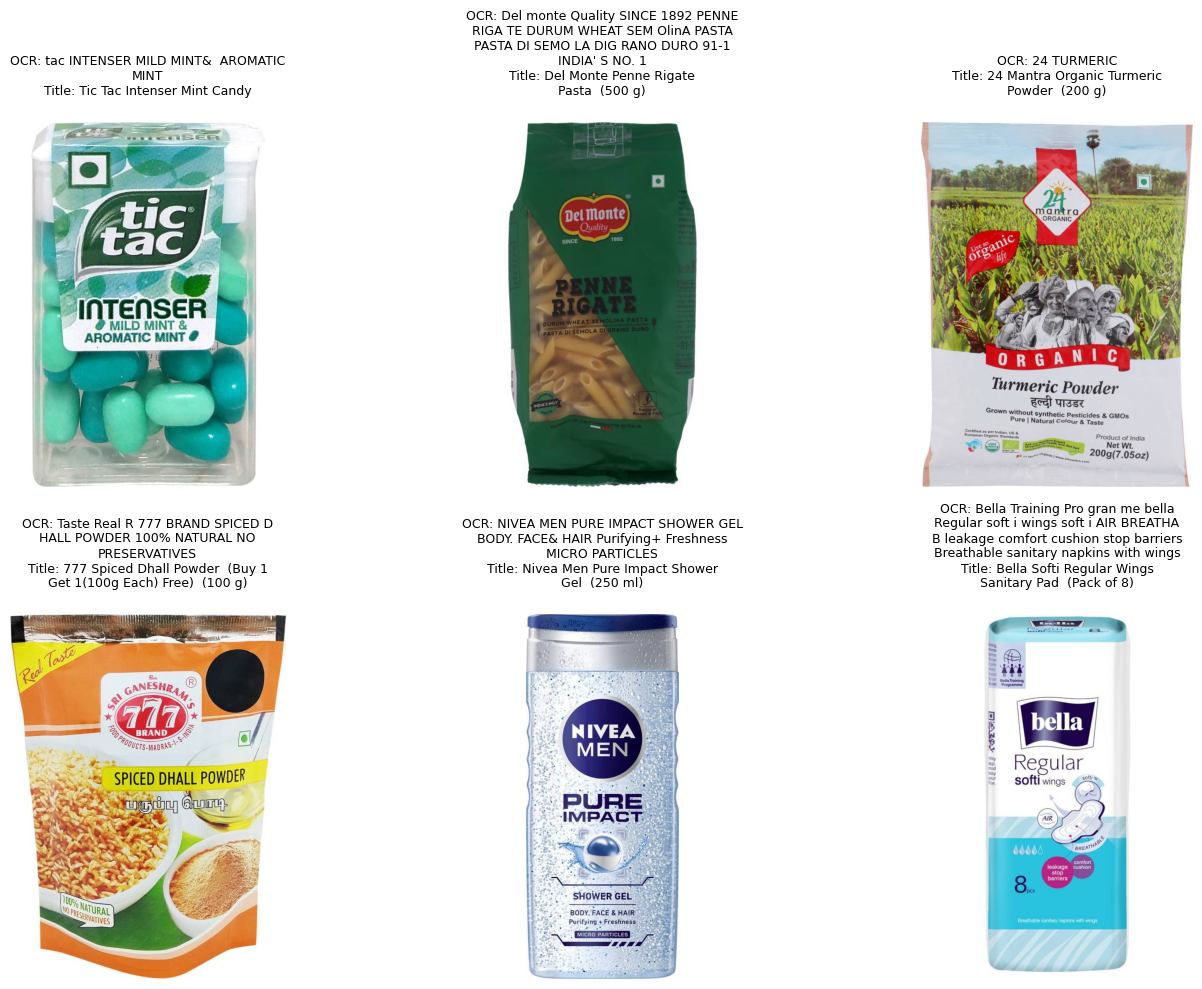

In [44]:
display_random_images_with_ocr(data)

Error loading image from URL: https://rukminim1.flixcart.com/image/832/832/k1jlyfk0/sweet-mithai/t/w/q/1-meetha-bandhan-assorted-sweets-bikano-original-imafh343qktmerpp.jpeg?q=70, ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end gene

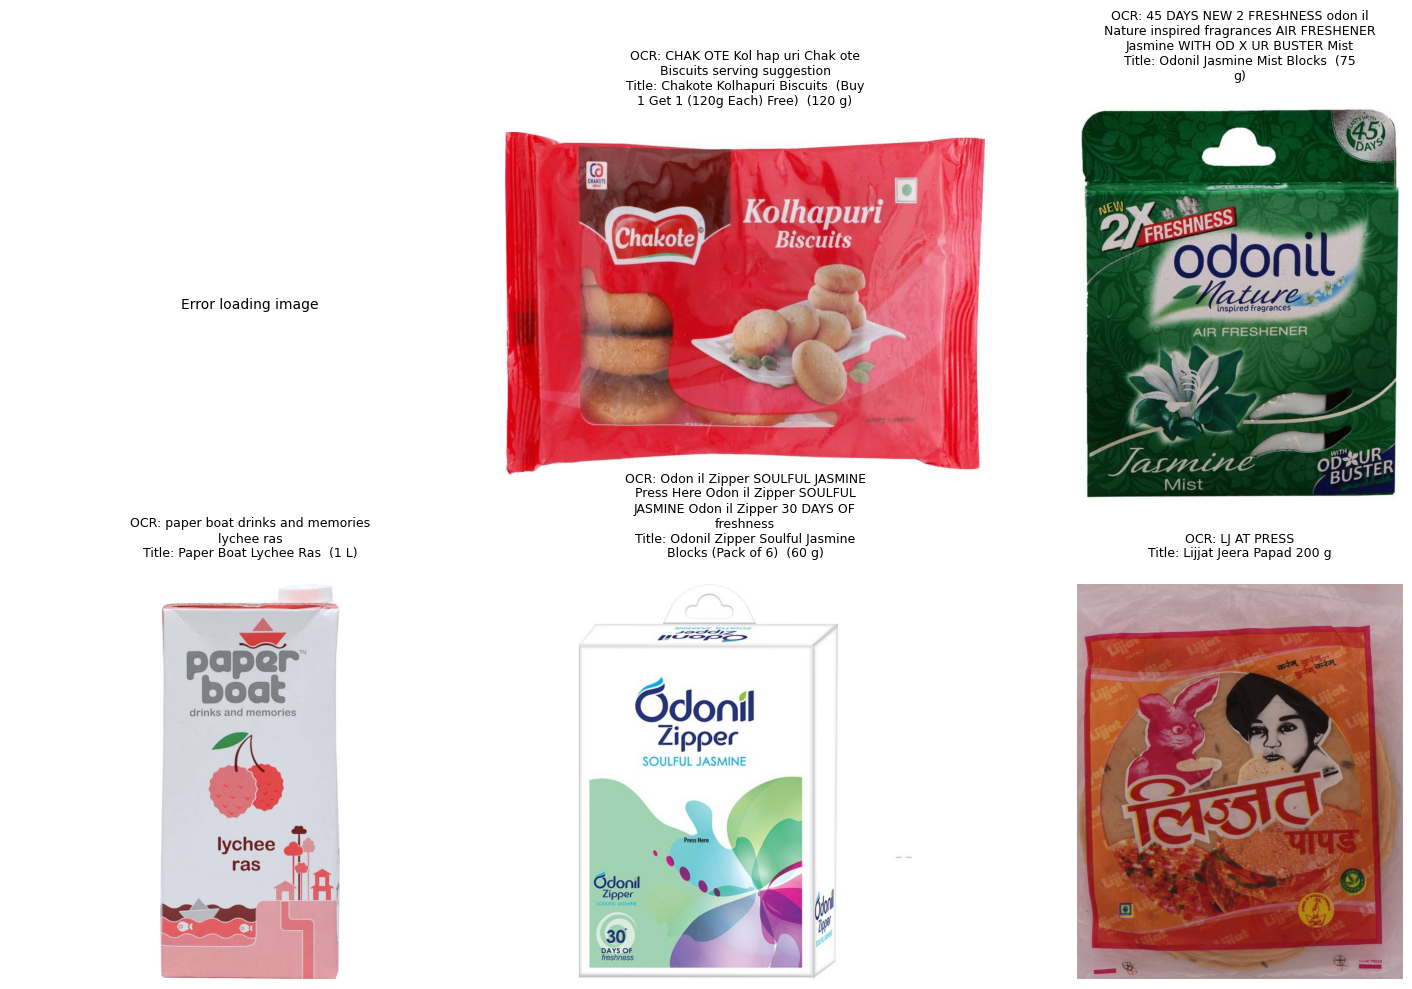

In [45]:
display_random_images_with_ocr(data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end gene

Error loading image from URL: https://rukminim1.flixcart.com/image/832/832/joynde80/chocolate/g/q/w/832-soft-centres-choco-mousse-fabelle-original-imafbb7tdabqykuu.jpeg?q=70, 404 Client Error: Not Found for url: https://rukminim1.flixcart.com/image/832/832/joynde80/chocolate/g/q/w/832-soft-centres-choco-mousse-fabelle-original-imafbb7tdabqykuu.jpeg?q=70


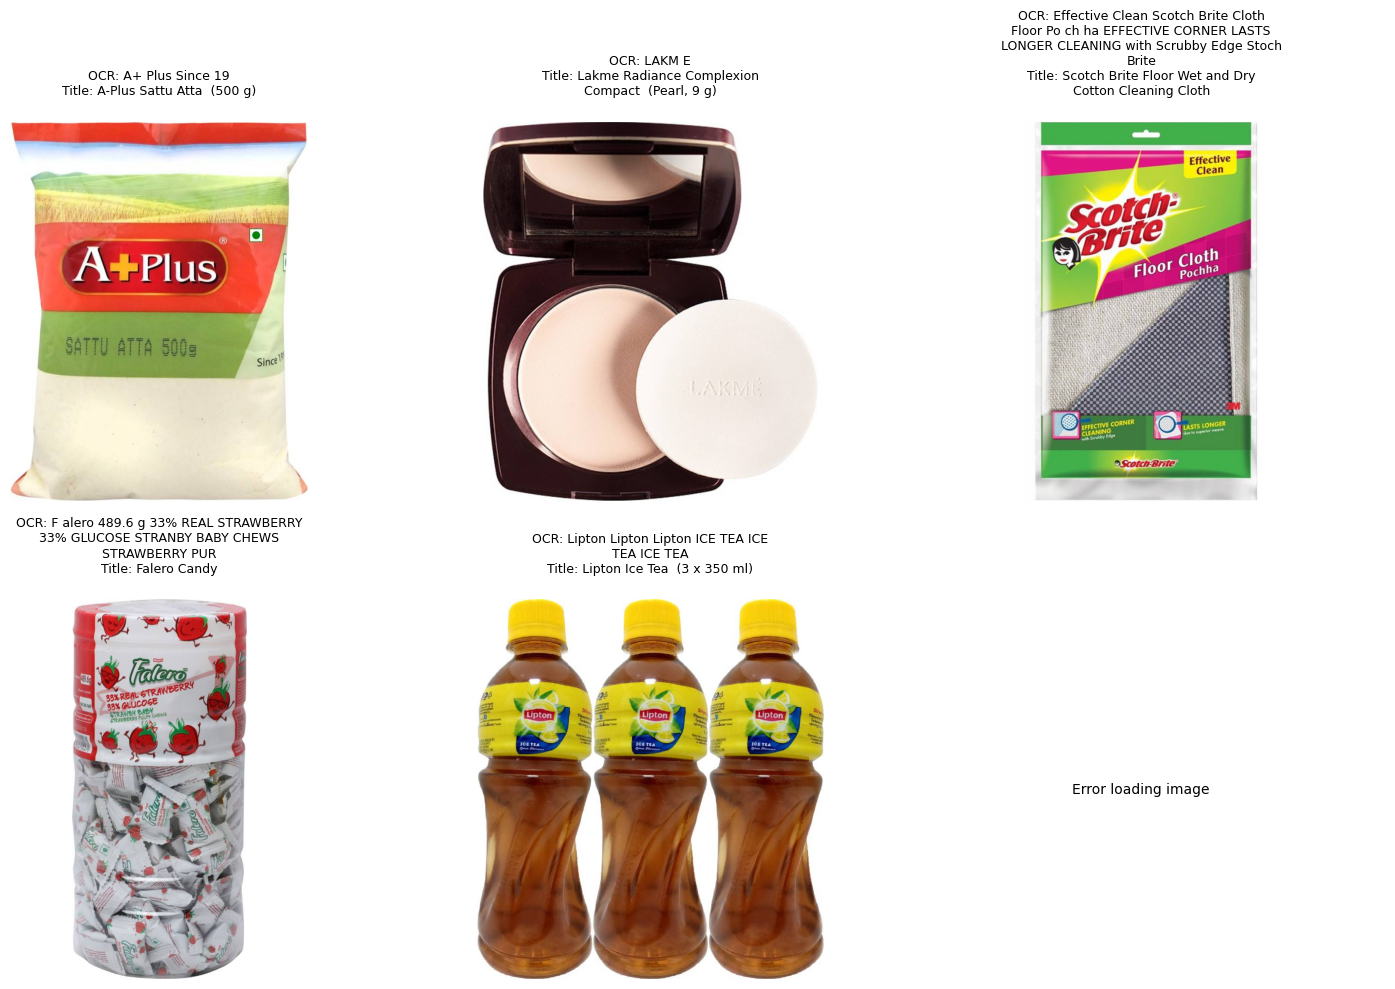

In [46]:
display_random_images_with_ocr(data)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


====new images batch size======:  
 torch.Size([7, 3, 1024, 1024])
PUNJABI CH
OLE MASALA
MADE WIT I READY IN 3 STEPS 100% VE G
NO


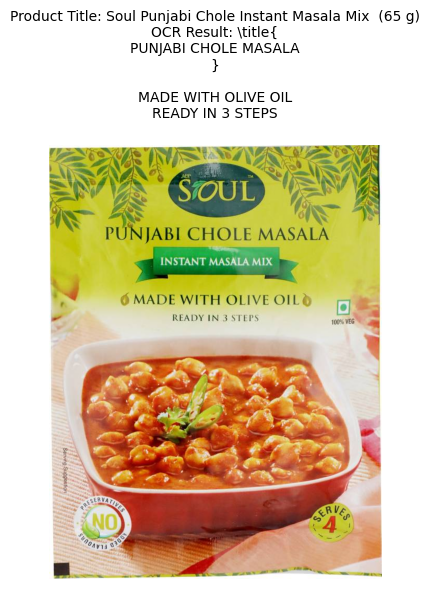

In [56]:
def plot_image_with_ocr(df, index , ocr_type):
    # Get the image URL and product title from the DataFrame
    image_url = df['Image Url'].iloc[index].split("|")[0]
    product_title = df['Product Title'].iloc[index]

    # Load the image from the URL
    img = load_image_from_url(image_url)

    # Perform OCR using the model.chat function
    ocr_res = model.chat(tokenizer, image_url, ocr_type=ocr_type , ocr_box="")
    res = model.chat_crop(tokenizer, image_url, ocr_type='ocr')
    print(res)
    # Plot the image with title and OCR result
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if img:
        ax.imshow(img)
        ax.axis('off')  # Remove axis labels
        
        # Set the title with product title and OCR result
        ax.set_title(f"Product Title: {product_title}\nOCR Result: {ocr_res}", fontsize=10, pad=20)
    else:
        ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame with 'Image Url' and 'Product Title' columns
plot_image_with_ocr(data, index=7 , ocr_type='format') 

---